In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Read in the data from csv
human_data = pd.read_csv('human data/reading speed decrement.csv')
simulated_data = pd.read_csv('0627_perturbation_fine_grid_search_results.csv')

# Filter simulated_data for dwell steps=0.2
simulated_data = simulated_data[
    (simulated_data['dwell_steps'] == 0.2)
#     & (simulated_data['perturbation_amp_noise_scale'] == 0.01)
]

In [2]:
%%time

def compute_cost(sim_ratio, human_ratio_mean):
    return np.abs(sim_ratio - human_ratio_mean)

# Lists to store results
results_list = []

num_iterations = 500  # 12 choose 6

for i in range(num_iterations):
    # 2. Split human data into train and test
    train, test = train_test_split(human_data, test_size=6, random_state=i)
    
    train_mean_ratio = np.mean(train['ratio'])
    test_mean_ratio = np.mean(test['ratio'])
    
    min_cost = float('inf')
    best_params = None
    sim_mean_ratio = None

    # 3. Find the closest match
    for index, row in simulated_data.iterrows():
        cost = compute_cost(row['walk_over_stand_percent'], train_mean_ratio)
        if cost < min_cost:
            min_cost = cost
            best_params = row
            sim_mean_ratio = row['walk_over_stand_percent']
            
    results_list.append({
        'perturbation_amp_tuning_factor': best_params['perturbation_amp_tuning_factor'],
        'perturbation_amp_noise_scale': best_params['perturbation_amp_noise_scale'],
        'train_mean_ratio': train_mean_ratio,
        'test_mean_ratio': test_mean_ratio,
        'sim_mean_ratio': sim_mean_ratio
    })

# Storing and displaying results
results = pd.DataFrame(results_list)
print(results)

# Save the DataFrame to a CSV file
results.to_csv('study2_readingspeeddecrement/plot_data.csv', index=False)  # 'results.csv' is the filename

     perturbation_amp_tuning_factor  perturbation_amp_noise_scale  \
0                              0.01                         0.006   
1                              0.00                         0.004   
2                              0.00                         0.004   
3                              0.00                         0.002   
4                              0.04                         0.004   
..                              ...                           ...   
495                            0.01                         0.006   
496                            0.02                         0.008   
497                            0.00                         0.002   
498                            0.00                         0.001   
499                            0.00                         0.006   

     train_mean_ratio  test_mean_ratio  sim_mean_ratio  
0            0.901272         0.983859        0.907692  
1            0.965695         0.919436        0.967213  


In [4]:
# RMSE
# Compute RMSE function
def compute_rmse(true_vals, predicted_vals):
    return np.sqrt(np.mean((np.array(true_vals) - np.array(predicted_vals)) ** 2))

# Calculate RMSE between test and simulated data
rmse = compute_rmse(results['test_mean_ratio']*100, results['sim_mean_ratio']*100)
print(f"Root Mean Square Error (RMSE) between test and simulated data: {rmse:.4f}")

Root Mean Square Error (RMSE) between test and simulated data: 8.9143


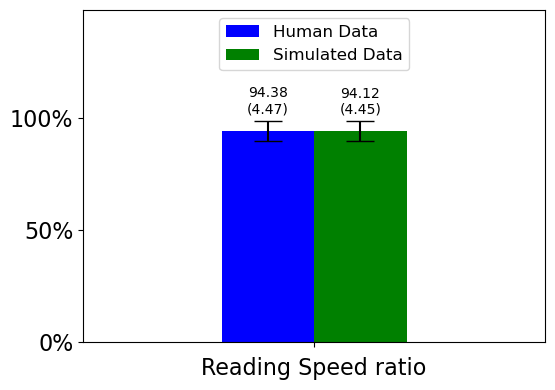

The file has been saved


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)
    
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
# Create the formatter using the function to_percent. This multiplies x by 100 and adds a percent symbol
formatter = FuncFormatter(to_percent)

# Given labels
labels = ['Walking Reading Speed vs Standing Reading Speed']
labels = []

# Calculate SEM
def std(data):
    return np.std(data) #/ np.sqrt(len(data))

# Extract means and SEM for the test and simulation data
mean_test_ratio = np.mean(results['test_mean_ratio']) * 100
std_test_ratio = std(results['test_mean_ratio']) * 100
mean_simulated_ratio = np.mean(results['sim_mean_ratio']) * 100
std_simulated_ratio = std(results['sim_mean_ratio']) * 100

# Plotting
x = np.array([0.5])  # set the x location to 0.5, so it's centered
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(6, 4))
fig.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.2)  # Adjust white space margins

rects1 = ax.bar(x - width/2, mean_test_ratio, width, label='Human Data', color='blue', yerr=std_test_ratio, capsize=10)
rects2 = ax.bar(x + width/2, mean_simulated_ratio, width, label='Simulated Data', color='green', yerr=std_simulated_ratio, capsize=10)

# Annotating bars with mean and SEM values
for rects, mean_val, std_val in [(rects1, mean_test_ratio, std_test_ratio), (rects2, mean_simulated_ratio, std_simulated_ratio)]:
    rect = rects[0]
    height = rect.get_height()
    
    # Annotate with mean value
    ax.annotate(f'{mean_val:.2f}\n({std_val:.2f})',
                xy=(rect.get_x() + rect.get_width() / 2, height + std_val + 0.02),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Labels, title, and custom x-axis tick labels

# ax.set_ylabel('Reading Speed ratio (%)', fontsize=14)
# Get the current y-ticks from the axis
# Define your custom ticks
custom_ticks = [0, 50, 100]
# Set the custom ticks
ax.set_yticks(custom_ticks)
y_ticks = ax.get_yticks()
# Filter out y-tick values that are 100 or greater
# ax_ticklabels = [f"{int(x)}%" for x in y_ticks]  # Append '%' to each tick
ax_ticklabels = [f"{int(x)}%" for x in custom_ticks]
ax.set_yticklabels(ax_ticklabels, fontsize=16)


ax.set_xlabel('Reading Speed ratio', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16, fontweight='bold')
ax.tick_params(axis='y', labelsize=16)  # Adjust the fontsize as desired for y-axis
ax.legend(fontsize=12, loc="upper center")

# Adjust y-axis limit
y_max = max(mean_test_ratio + std_test_ratio, mean_simulated_ratio + std_simulated_ratio)
ax.set_ylim(0, y_max * 1.5)  # Adding a bit of margin to the top
ax.set_xlim(0, 1)

fig.tight_layout()

fig.savefig('study2_readingspeeddecrement/study2_readingspeedratio.pdf', format='pdf', dpi=300)
plt.show(fig)

print(f"The file has been saved")